In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta as ta
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#

In [2]:
Base="EUR"
Quote="USD"
Pair=Base+Quote

ticker = "EURUSD=X"
#start="2021-01-01"
start=pd.to_datetime('2021-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')


initial_wealth = 1

In [3]:
#Deposit Rate
#https://www.interactivebrokers.com/en/accounts/fees/pricing-interest-rates.php
USD_deposit_interest=0.0483
JPY_deposit_interest=-0.00257
EUR_deposit_interest=0.03427
GBP_deposit_interest=0.04682
AUD_deposit_interest=0.03769
NZD_deposit_interest=0.02835
CAD_deposit_interest=0.04343
CNH_deposit_interest=0.0050
SGD_deposit_interest=0.02642

#Margin Rate
#https://www.interactivebrokers.com/en/trading/margin-rates.php
USD_margin_interest=0.0683
JPY_margin_interest=0.015
EUR_margin_interest=0.05427
GBP_margin_interest=0.06682
AUD_margin_interest=0.05769
NZD_margin_interest=0.06835
CAD_margin_interest=0.06343
CNH_margin_interest=0.06234
SGD_margin_interest=0.05142

#Deposit_interest=Base+"_deposit_interest"
#Margin_interest=Quote+"_margin_interest"

#Trading Cost
Trading_cost=0.000002
#https://www.interactivebrokers.com/en/pricing/commissions-spot-currencies.php

#Used for calculating Sharpe, can also be used as hurdle rate
riskfree_rate = 0.03


In [4]:
# download daily stock price data by passing in specified ticker and date range

df = yf.download(ticker,start,end=today_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
fig = go.Figure(data=go.Scatter(x=df.index,y=df['Close'],mode='lines'))
fig.show()

In [6]:
#Change interest rates accordingly
df['returns'] = np.log(df['Close'] / df['Close'].shift(1)) +(EUR_deposit_interest-USD_margin_interest)/365.25

print(df)

                Open      High       Low     Close  Adj Close  Volume  \
Date                                                                    
2021-01-01  1.217285  1.221699  1.213499  1.218027   1.218027       0   
2021-01-04  1.224905  1.230999  1.217137  1.225070   1.225070       0   
2021-01-05  1.225295  1.229483  1.224995  1.225160   1.225160       0   
2021-01-06  1.229861  1.235025  1.226693  1.230027   1.230027       0   
2021-01-07  1.233776  1.234568  1.224665  1.234111   1.234111       0   
...              ...       ...       ...       ...        ...     ...   
2024-05-21  1.086083  1.087548  1.084599  1.086083   1.086083       0   
2024-05-22  1.085517  1.086484  1.082251  1.085517   1.085517       0   
2024-05-23  1.082520  1.086130  1.081303  1.082520   1.082520       0   
2024-05-24  1.081268  1.085658  1.080614  1.081268   1.081268       0   
2024-05-27  1.084763  1.086720  1.084175  1.084763   1.084763       0   

             returns  
Date                  
2021

In [7]:
np.exp(df['returns']).cumprod()[-1] -1

-0.1799730869572267

In [8]:
# drawdown of buy and hold
df['wealth_buy_and_hold_strategy'] = initial_wealth*(1+df['returns']).cumprod()
df['prior_peaks_buy_and_hold_strategy'] = df['wealth_buy_and_hold_strategy'].cummax()
drawdown_buy_and_hold_strategy = (df['wealth_buy_and_hold_strategy']  - df['prior_peaks_buy_and_hold_strategy'])/df['prior_peaks_buy_and_hold_strategy']
print(drawdown_buy_and_hold_strategy.min())
print(drawdown_buy_and_hold_strategy.idxmin())

-0.25788203475043014
2022-09-28 00:00:00


In [9]:
# terminal return of buy-n-hold
np.exp(df['returns']).cumprod()[-1] -1

# calculate annualized return of buy-n-hold
annualized_return_buy_n_hold = np.exp(df['returns']).prod()**(252/df.shape[0])-1
annualized_return_buy_n_hold

# calculate annualized volatility of buy-n-hold
annualized_vol_buy_n_hold = (np.exp(df['returns'])-1).std()*(252**0.5)
annualized_vol_buy_n_hold

riskfree_rate = 0.03
# calculate Sharpe ratio of buy-n-hold
sharpe_ratio_buy_n_hold =(annualized_return_buy_n_hold - riskfree_rate) /annualized_vol_buy_n_hold
sharpe_ratio_buy_n_hold

-1.1245974098635543

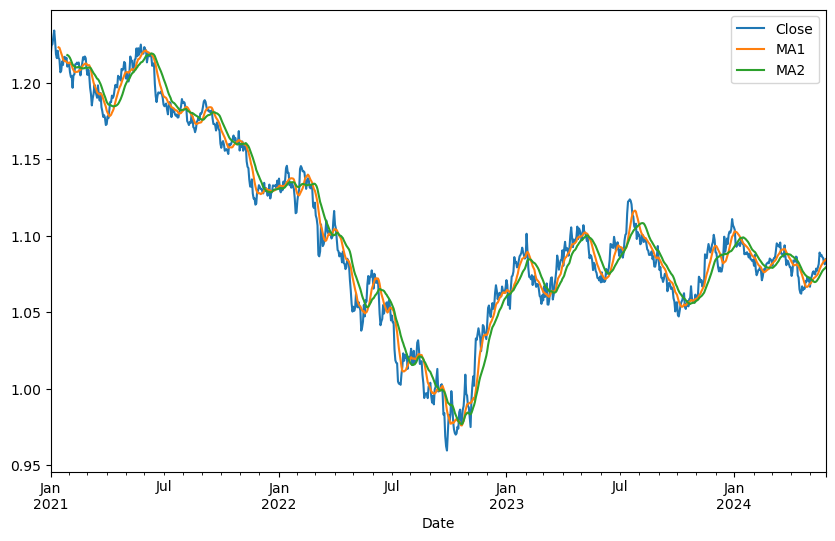

In [10]:
window1 = 10
window2 = 20

df['MA1'] = df['Close'].rolling(window1).mean()
df['MA2'] = df['Close'].rolling(window2).mean()

df[['Close', 'MA1','MA2']].plot(figsize=(10, 6));

In [11]:
df['MAposition'] = np.where(df['MA1'] > df['MA2'],1, -1)

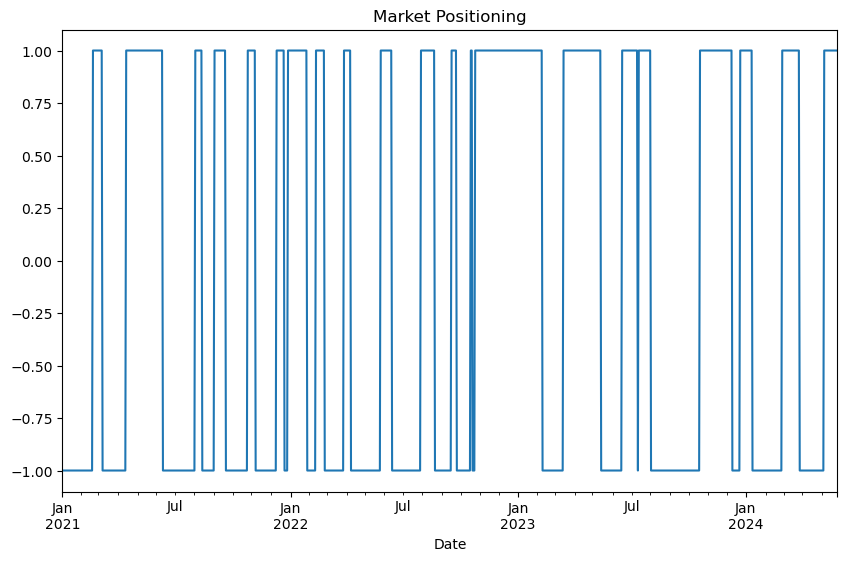

In [12]:
df['MAposition'].plot(ylim=[-1.1, 1.1],
title='Market Positioning',
figsize=(10, 6));

In [13]:
df['MAstrategy'] = df['MAposition'].shift(1) * df['returns']

In [14]:
df['newtrade_MAstrategy']=(df['MAposition'])-(df['MAposition'].shift(1))

df['newtrade_MAstrategyreturn']= 0

df.reset_index(inplace=True)
for i in range(1, len(df)):
    if df.loc[i, 'newtrade_MAstrategy'] == 2:
        df.loc[i, 'newtrade_MAstrategyreturn'] = 0
    elif df.loc[i, 'newtrade_MAstrategy'] == -2:
        df.loc[i, 'newtrade_MAstrategyreturn'] = 0
    else:
        df.loc[i, 'newtrade_MAstrategyreturn'] = df.loc[i - 1, 'newtrade_MAstrategyreturn'] + df.loc[i, 'MAstrategy']

In [15]:
df['SL_MAposition']= 0

for i in range(1, len(df)):
    if df.loc[i, 'newtrade_MAstrategyreturn'] >= -0.01:
        df.loc[i, 'SL_MAposition'] = df['MAposition'][i]
    else:
        df.loc[i:i+5, 'SL_MAposition'] = 0

In [16]:
df['SL_MAstrategy'] = df['SL_MAposition'].shift(1) * df['returns']
df.set_index(df['Date'], drop=True,inplace=True)
df.drop(columns=['Date', 'Open','High','Low','Volume'],inplace=True)

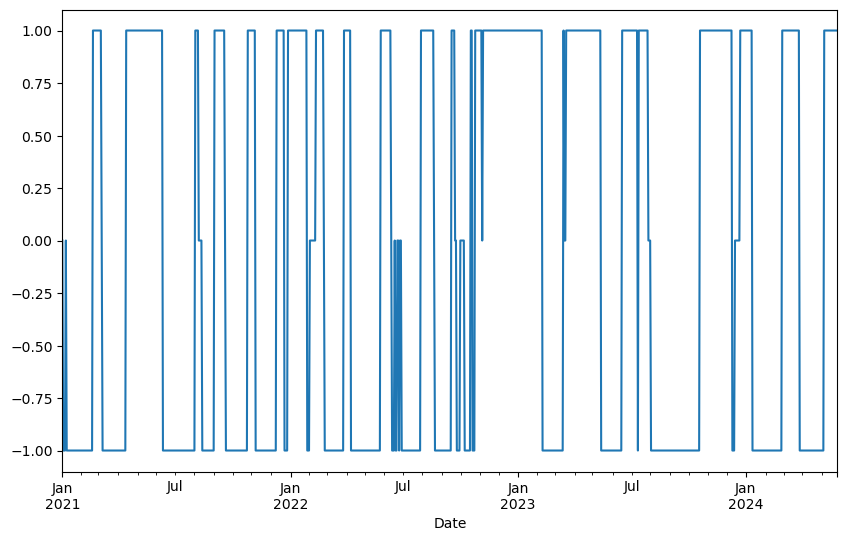

In [17]:
df['SL_MAposition'].plot(figsize=(10, 6));

In [18]:
#df.head(30)

In [19]:
# drawdown of MAstrategy
df['wealth_MAstrategy'] = initial_wealth*(1+df['MAstrategy']).cumprod()
df['prior_peaks_MAstrategy'] = df['wealth_MAstrategy'].cummax()
drawdown_MAstrategy = (df['wealth_MAstrategy']  - df['prior_peaks_MAstrategy'])/df['prior_peaks_MAstrategy']
print(drawdown_MAstrategy.min())
print(drawdown_MAstrategy.idxmin())

-0.13263970709329426
2022-11-04 00:00:00


In [20]:
# terminal return of MAstrategy
np.exp(df['MAstrategy']).cumprod()[-1] -1

# calculate annualized return of MAstrategy
annualized_return_MAstrategy = np.exp(df['MAstrategy']).prod()**(252/df.shape[0])-1
annualized_return_MAstrategy

# calculate annualized volatility of MAstrategy
annualized_vol_MAstrategy = (np.exp(df['MAstrategy'])-1).std()*(252**0.5)
annualized_vol_MAstrategy

riskfree_rate = 0.03
# calculate Sharpe ratio of MAstrategy
sharpe_ratio_MAstrategy =(annualized_return_MAstrategy - riskfree_rate) /annualized_vol_MAstrategy
sharpe_ratio_MAstrategy

-0.17602605129352547

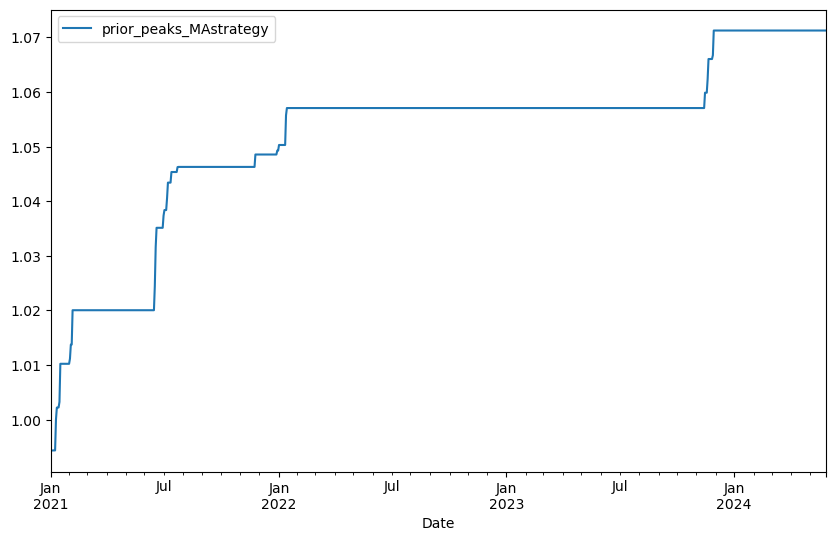

In [21]:
df[['prior_peaks_MAstrategy']].plot(figsize=(10, 6));

In [22]:
# drawdown of SL_MAstrategy
df['wealth_SL_MAstrategy'] = initial_wealth*(1+df['SL_MAstrategy']).cumprod()
df['prior_peaks_SL_MAstrategy'] = df['wealth_SL_MAstrategy'].cummax()
drawdown_SL_MAstrategy = (df['wealth_SL_MAstrategy']  - df['prior_peaks_SL_MAstrategy'])/df['prior_peaks_SL_MAstrategy']
print(drawdown_SL_MAstrategy.min())
print(drawdown_SL_MAstrategy.idxmin())

-0.10593497665929168
2022-11-04 00:00:00


In [23]:
# terminal return of SL_MAstrategy
np.exp(df['SL_MAstrategy']).cumprod()[-1] -1

# calculate annualized return of SL_MAstrategy
annualized_return_SL_MAstrategy = np.exp(df['SL_MAstrategy']).prod()**(252/df.shape[0])-1
annualized_return_SL_MAstrategy

# calculate annualized volatility of SL_MAstrategy
annualized_vol_SL_MAstrategy = (np.exp(df['SL_MAstrategy'])-1).std()*(252**0.5)
annualized_vol_SL_MAstrategy

riskfree_rate = 0.03
# calculate Sharpe ratio of SL_MAstrategy
sharpe_ratio_SL_MAstrategy =(annualized_return_SL_MAstrategy - riskfree_rate) /annualized_vol_SL_MAstrategy
sharpe_ratio_SL_MAstrategy

-0.10350988267538512

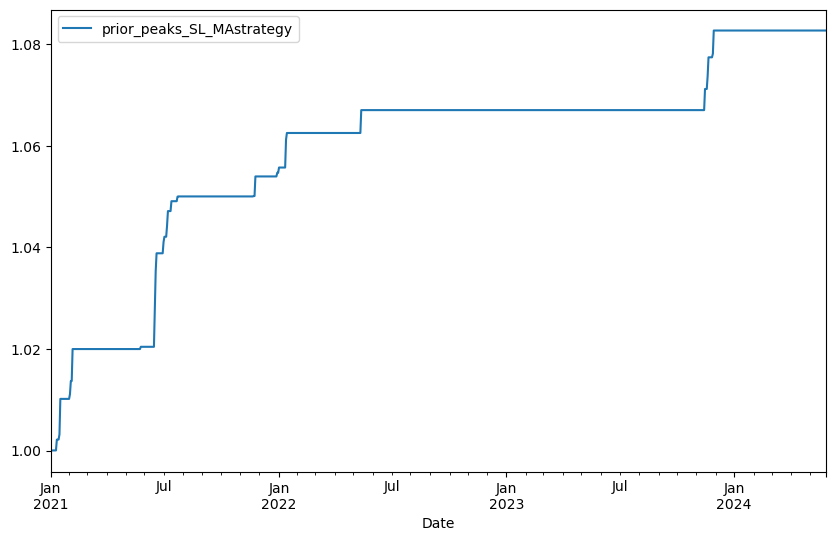

In [24]:
df[['prior_peaks_SL_MAstrategy']].plot(figsize=(10, 6));

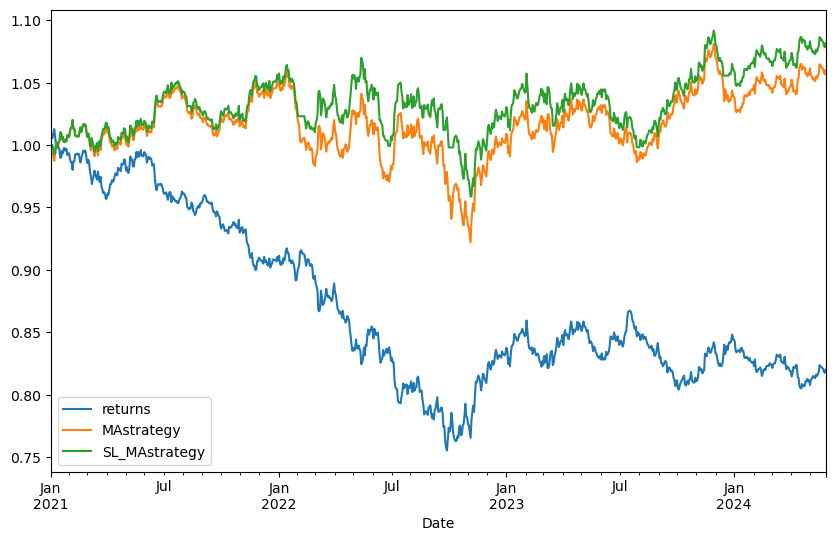

In [25]:
df[['returns', 'MAstrategy','SL_MAstrategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [26]:
# Calculate RSI
df["RSI"] =ta.momentum.RSIIndicator(df["Close"],window=14, fillna= False).rsi()

In [27]:
#df['RSIposition'] = np.where(df['RSI'] > 70,1, 0)
df['RSIposition'] = np.nan
df['RSIposition'][df['RSI']> 70] = -1
df['RSIposition'][df['RSI'] < 30] = 1
df['RSIposition'][(df['RSI'] <= 70) & (df['RSI'] >= 30)] = 0

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_97751/3762989194.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_97751/3762989194.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_97751/3762989194.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



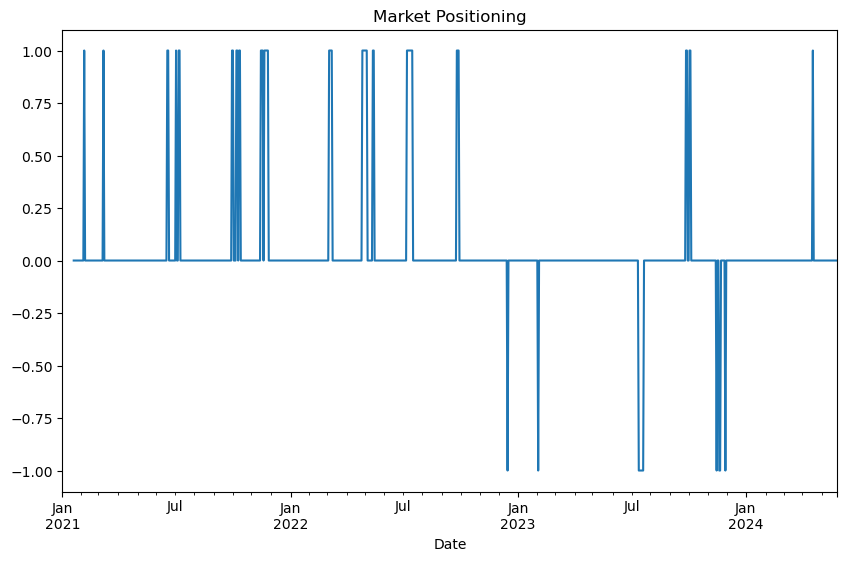

In [28]:
df['RSIposition'].plot(ylim=[-1.1, 1.1],
title='Market Positioning',
figsize=(10, 6));

In [29]:
df['RSIstrategy'] = df['RSIposition'].shift(1) * df['returns']

In [30]:
# drawdown of RSIstrategy
df['wealth_RSIstrategy'] = initial_wealth*(1+df['RSIstrategy']).cumprod()
df['prior_peaks_RSIstrategy'] = df['wealth_RSIstrategy'].cummax()
drawdown_RSIstrategy = (df['wealth_RSIstrategy']  - df['prior_peaks_RSIstrategy'])/df['prior_peaks_RSIstrategy']
print(drawdown_RSIstrategy.min())
print(drawdown_RSIstrategy.idxmin())

-0.019378291000812606
2022-09-28 00:00:00


In [31]:
# terminal return of RSIstrategy
np.exp(df['RSIstrategy']).cumprod()[-1] -1

# calculate annualized return of RSIstrategy
annualized_return_RSIstrategy = np.exp(df['RSIstrategy']).prod()**(252/df.shape[0])-1
annualized_return_RSIstrategy

# calculate annualized volatility of RSIstrategy
annualized_vol_RSIstrategy = (np.exp(df['RSIstrategy'])-1).std()*(252**0.5)
annualized_vol_RSIstrategy

# calculate Sharpe ratio of RSIstrategy
sharpe_ratio_RSIstrategy =(annualized_return_RSIstrategy - riskfree_rate) /annualized_vol_RSIstrategy
sharpe_ratio_RSIstrategy

-0.8365262792780042

In [32]:
#df['newtrade_RSIstrategy']=(df['RSIposition'])-(df['RSIposition'].shift(1))

df['newtrade_RSIstrategyreturn']= 0

df.reset_index(inplace=True)
for i in range(1, len(df)):
    if (df.loc[i, 'RSIposition'] == 1) & (df.loc[i-1, 'RSIposition'] == 0):
        df.loc[i, 'newtrade_RSIstrategyreturn'] = 0
    elif (df.loc[i, 'RSIposition'] == -1) & (df.loc[i-1, 'RSIposition'] == 0):
        df.loc[i, 'newtrade_RSIstrategyreturn'] = 0
    else:
        df.loc[i, 'newtrade_RSIstrategyreturn'] = df.loc[i - 1, 'newtrade_RSIstrategyreturn'] + df.loc[i, 'RSIstrategy']

In [33]:
df['SL_RSIposition']= 0

for i in range(1, len(df)):
    if df.loc[i, 'newtrade_RSIstrategyreturn'] >= -0.01:
        df.loc[i, 'SL_RSIposition'] = df['RSIposition'][i]
    else:
        df.loc[i:i+5, 'SL_RSIposition'] = 0

In [34]:
df['SL_RSIstrategy'] = df['SL_RSIposition'].shift(1) * df['returns']
df.set_index(df['Date'], drop=True,inplace=True)
df.drop(columns=['Date'],inplace=True)

In [35]:
# drawdown of SL_RSIstrategy
df['wealth_SL_RSIstrategy'] = initial_wealth*(1+df['SL_RSIstrategy']).cumprod()
df['prior_peaks_SL_RSIstrategy'] = df['wealth_SL_RSIstrategy'].cummax()
drawdown_SL_RSIstrategy = (df['wealth_SL_RSIstrategy']  - df['prior_peaks_SL_RSIstrategy'])/df['prior_peaks_SL_RSIstrategy']
print(drawdown_SL_RSIstrategy.min())
print(drawdown_SL_RSIstrategy.idxmin())

-0.04849044738958778
2022-09-28 00:00:00


In [36]:
# terminal return of SL_RSIstrategy
np.exp(df['SL_RSIstrategy']).cumprod()[-1] -1

# calculate annualized return of RSIstrategy
annualized_return_SL_RSIstrategy = np.exp(df['SL_RSIstrategy']).prod()**(252/df.shape[0])-1
annualized_return_SL_RSIstrategy

# calculate annualized volatility of RSIstrategy
annualized_vol_SL_RSIstrategy = (np.exp(df['SL_RSIstrategy'])-1).std()*(252**0.5)
annualized_vol_SL_RSIstrategy

# calculate Sharpe ratio of RSIstrategy
sharpe_ratio_SL_RSIstrategy =(annualized_return_SL_RSIstrategy - riskfree_rate) /annualized_vol_SL_RSIstrategy
sharpe_ratio_SL_RSIstrategy

-1.4455187472046287

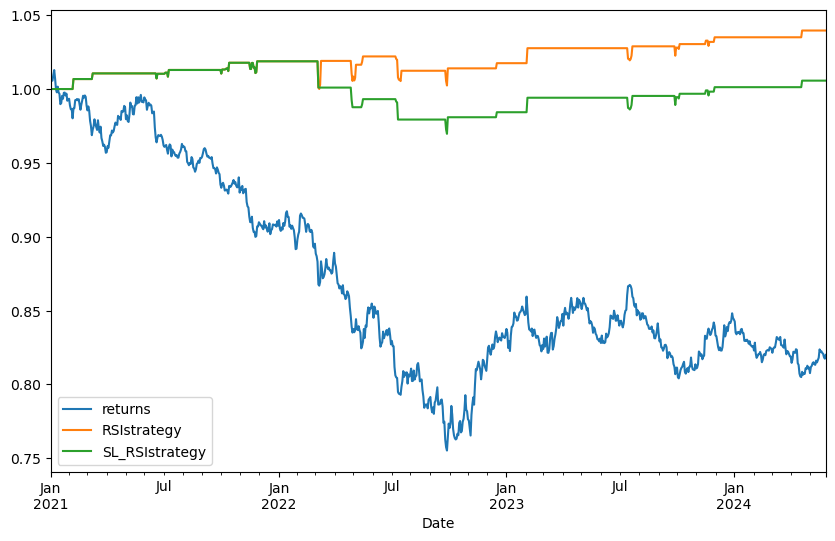

In [37]:
df[['returns', 'RSIstrategy','SL_RSIstrategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [62]:
# Calculate Bollinger Bands
bbands = ta.volatility.BollingerBands(df["Close"],window=20, window_dev=1)
df["BB_upper"] = bbands.bollinger_hband()
df["BB_lower"] = bbands.bollinger_lband()

In [63]:
df['BBposition'] = np.nan
df['BBposition'][df["Close"]>df["BB_upper"]] = -1
df['BBposition'][df["Close"] < df["BB_lower"]] = 1
df['BBposition'][(df["Close"] <= df["BB_upper"]) & (df["Close"] >= df["BB_lower"])] = 0

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_97751/3788525752.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_97751/3788525752.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_97751/3788525752.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



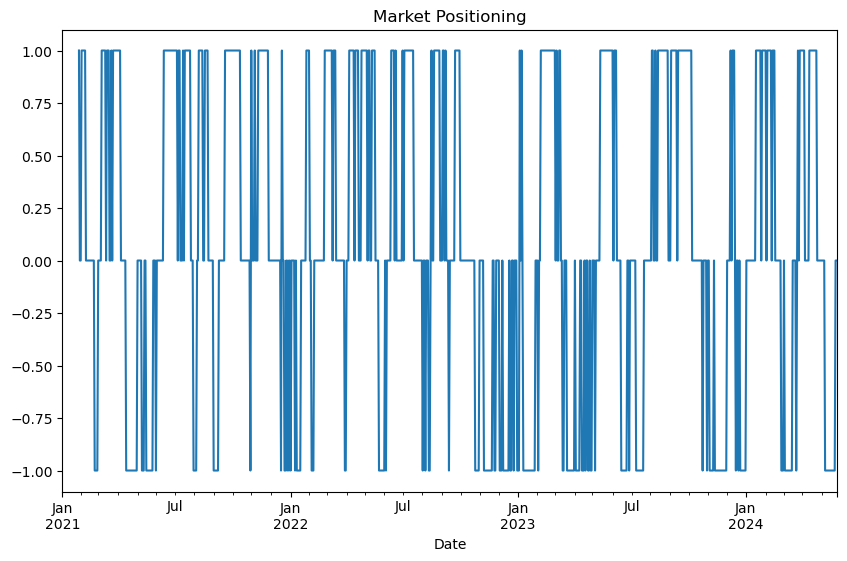

In [64]:
df['BBposition'].plot(ylim=[-1.1, 1.1],
title='Market Positioning',
figsize=(10, 6));

In [65]:
df['BBstrategy'] = df['BBposition'].shift(1) * df['returns']

In [66]:
# drawdown of BBstrategy
df['wealth_BBstrategy'] = initial_wealth*(1+df['BBstrategy']).cumprod()
df['prior_peaks_BBstrategy'] = df['wealth_BBstrategy'].cummax()
drawdown_BBstrategy = (df['wealth_BBstrategy']  - df['prior_peaks_BBstrategy'])/df['prior_peaks_BBstrategy']
print(drawdown_BBstrategy.min())
print(drawdown_BBstrategy.idxmin())

-0.07308476428477725
2023-11-29 00:00:00


In [67]:
# terminal return of BBstrategy
np.exp(df['BBstrategy']).cumprod()[-1] -1

# calculate annualized return of BBstrategy
annualized_return_BBstrategy = np.exp(df['BBstrategy']).prod()**(252/df.shape[0])-1
annualized_return_BBstrategy

# calculate annualized volatility of BBstrategy
annualized_vol_BBstrategy = (np.exp(df['BBstrategy'])-1).std()*(252**0.5)
annualized_vol_BBstrategy

# calculate Sharpe ratio of BBstrategy
sharpe_ratio_BBstrategy =(annualized_return_BBstrategy - riskfree_rate) /annualized_vol_BBstrategy
sharpe_ratio_BBstrategy

-0.3274783858288382

In [68]:
df['newtrade_BBstrategyreturn']= 0

df.reset_index(inplace=True)
for i in range(1, len(df)):
    if (df.loc[i, 'BBposition'] == 1) & (df.loc[i-1, 'BBposition'] == 0):
        df.loc[i, 'newtrade_BBstrategyreturn'] = 0
    elif (df.loc[i, 'BBposition'] == -1) & (df.loc[i-1, 'BBposition'] == 0):
        df.loc[i, 'newtrade_BBstrategyreturn'] = 0
    else:
        df.loc[i, 'newtrade_BBstrategyreturn'] = df.loc[i - 1, 'newtrade_BBstrategyreturn'] + df.loc[i, 'BBstrategy']

In [69]:
df['SL_BBposition']= 0

for i in range(1, len(df)):
    if df.loc[i, 'newtrade_BBstrategyreturn'] >= -0.01:
        df.loc[i, 'SL_BBposition'] = df['BBposition'][i]
    else:
        df.loc[i:i+5, 'SL_BBposition'] = 0

In [70]:
df['SL_BBstrategy'] = df['SL_BBposition'].shift(1) * df['returns']
df.set_index(df['Date'], drop=True,inplace=True)
df.drop(columns=['Date'],inplace=True)

In [71]:
# drawdown of SL_BBstrategy
df['wealth_SL_BBstrategy'] = initial_wealth*(1+df['SL_BBstrategy']).cumprod()
df['prior_peaks_SL_BBstrategy'] = df['wealth_SL_BBstrategy'].cummax()
drawdown_SL_BBstrategy = (df['wealth_SL_BBstrategy']  - df['prior_peaks_SL_BBstrategy'])/df['prior_peaks_SL_BBstrategy']
print(drawdown_SL_BBstrategy.min())
print(drawdown_SL_BBstrategy.idxmin())

-0.08354272630115576
2023-11-15 00:00:00


In [72]:
# terminal return of SL_BBstrategy
np.exp(df['SL_BBstrategy']).cumprod()[-1] -1

# calculate annualized return of SL_BBstrategy
annualized_return_SL_BBstrategy = np.exp(df['SL_BBstrategy']).prod()**(252/df.shape[0])-1
annualized_return_SL_BBstrategy

# calculate annualized volatility of BBstrategy
annualized_vol_SL_BBstrategy = (np.exp(df['SL_BBstrategy'])-1).std()*(252**0.5)
annualized_vol_SL_BBstrategy

# calculate Sharpe ratio of BBstrategy
sharpe_ratio_SL_BBstrategy =(annualized_return_SL_BBstrategy - riskfree_rate) /annualized_vol_SL_BBstrategy
sharpe_ratio_SL_BBstrategy

-0.825280705011538

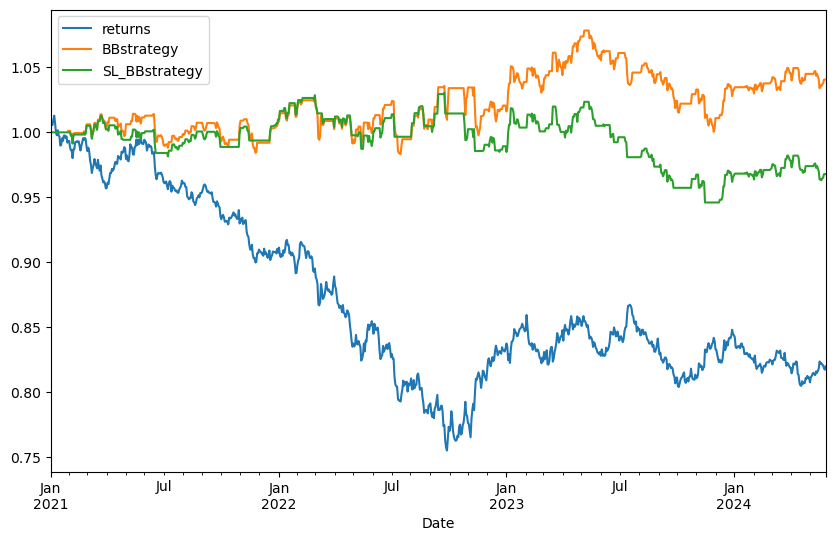

In [73]:
df[['returns', 'BBstrategy','SL_BBstrategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [50]:
# Calculate MACD
macd = ta.trend.MACD(df["Close"],window_slow= 26, window_fast= 12, window_sign= 9)
df["MACD"] = macd.macd()
df["MACD_signal"] = macd.macd_signal()

In [51]:
df['MACDposition'] = np.where(df['MACD'] > df['MACD_signal'],1, -1)

In [52]:
df['MACDstrategy'] = df['MACDposition'].shift(1) * df['returns']

In [53]:
df['newtrade_MACDstrategy']=(df['MACDposition'])-(df['MACDposition'].shift(1))

df['newtrade_MACDstrategyreturn']= 0

df.reset_index(inplace=True)
for i in range(1, len(df)):
    if df.loc[i, 'newtrade_MACDstrategy'] == 2:
        df.loc[i, 'newtrade_MACDstrategyreturn'] = 0
    elif df.loc[i, 'newtrade_MACDstrategy'] == -2:
        df.loc[i, 'newtrade_MACDstrategyreturn'] = 0
    else:
        df.loc[i, 'newtrade_MACDstrategyreturn'] = df.loc[i - 1, 'newtrade_MACDstrategyreturn'] + df.loc[i, 'MACDstrategy']

In [54]:
df['SL_MACDposition']= 0

for i in range(1, len(df)):
    if df.loc[i, 'newtrade_MACDstrategyreturn'] >= -0.01:
        df.loc[i, 'SL_MACDposition'] = df['MACDposition'][i]
    else:
        df.loc[i:i+5, 'SL_MACDposition'] = 0

In [55]:
df['SL_MACDstrategy'] = df['SL_MACDposition'].shift(1) * df['returns']
df.set_index(df['Date'], drop=True,inplace=True)
df.drop(columns=['Date'],inplace=True)

In [56]:
# drawdown of MACDstrategy
df['wealth_MACDstrategy'] = initial_wealth*(1+df['MACDstrategy']).cumprod()
df['prior_peaks_MACDstrategy'] = df['wealth_MACDstrategy'].cummax()
drawdown_MACDstrategy = (df['wealth_MACDstrategy']  - df['prior_peaks_MACDstrategy'])/df['prior_peaks_MACDstrategy']
print(drawdown_MACDstrategy.min())
print(drawdown_MACDstrategy.idxmin())

-0.17465105732058558
2023-03-16 00:00:00


In [57]:
# terminal return of MACDstrategy
np.exp(df['MACDstrategy']).cumprod()[-1] -1

# calculate annualized return of MACDstrategy
annualized_return_MACDstrategy = np.exp(df['MACDstrategy']).prod()**(252/df.shape[0])-1
annualized_return_MACDstrategy

# calculate annualized volatility of MAstrategy
annualized_vol_MACDstrategy = (np.exp(df['MACDstrategy'])-1).std()*(252**0.5)
annualized_vol_MACDstrategy

# calculate Sharpe ratio of MACDstrategy
sharpe_ratio_MACDstrategy =(annualized_return_MACDstrategy - riskfree_rate) /annualized_vol_MACDstrategy
sharpe_ratio_MACDstrategy

-0.5234424045463456

In [58]:
# drawdown of SL_MACDstrategy
df['wealth_SL_MACDstrategy'] = initial_wealth*(1+df['SL_MACDstrategy']).cumprod()
df['prior_peaks_SL_MACDstrategy'] = df['wealth_SL_MACDstrategy'].cummax()
drawdown_SL_MACDstrategy = (df['wealth_SL_MACDstrategy']  - df['prior_peaks_SL_MACDstrategy'])/df['prior_peaks_SL_MACDstrategy']
print(drawdown_SL_MACDstrategy.min())
print(drawdown_SL_MACDstrategy.idxmin())

-0.16542709280829634
2023-03-16 00:00:00


In [59]:
# terminal return of SL_MACDstrategy
np.exp(df['SL_MACDstrategy']).cumprod()[-1] -1

# calculate annualized return of MACDstrategy
annualized_return_SL_MACDstrategy = np.exp(df['SL_MACDstrategy']).prod()**(252/df.shape[0])-1
annualized_return_SL_MACDstrategy

# calculate annualized volatility of MAstrategy
annualized_vol_SL_MACDstrategy = (np.exp(df['SL_MACDstrategy'])-1).std()*(252**0.5)
annualized_vol_SL_MACDstrategy

# calculate Sharpe ratio of MACDstrategy
sharpe_ratio_SL_MACDstrategy =(annualized_return_MACDstrategy - riskfree_rate) /annualized_vol_MACDstrategy
sharpe_ratio_SL_MACDstrategy

-0.5234424045463456

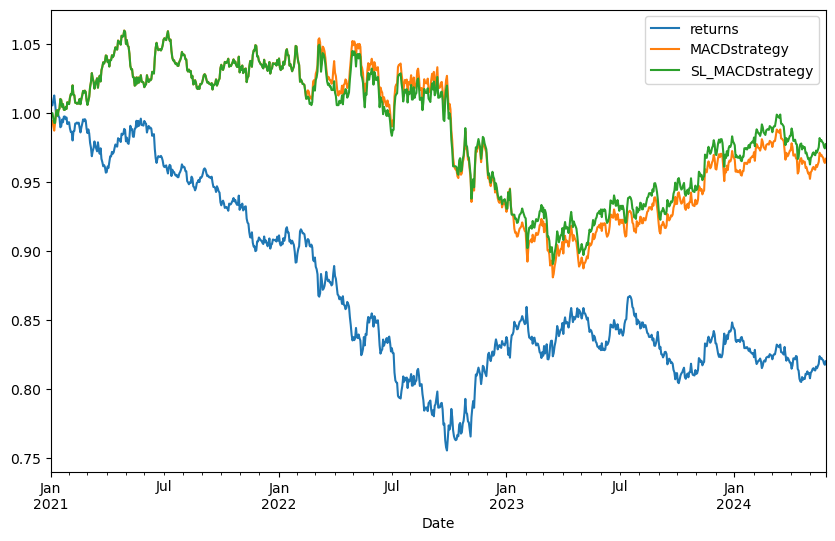

In [60]:
df[['returns', 'MACDstrategy','SL_MACDstrategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

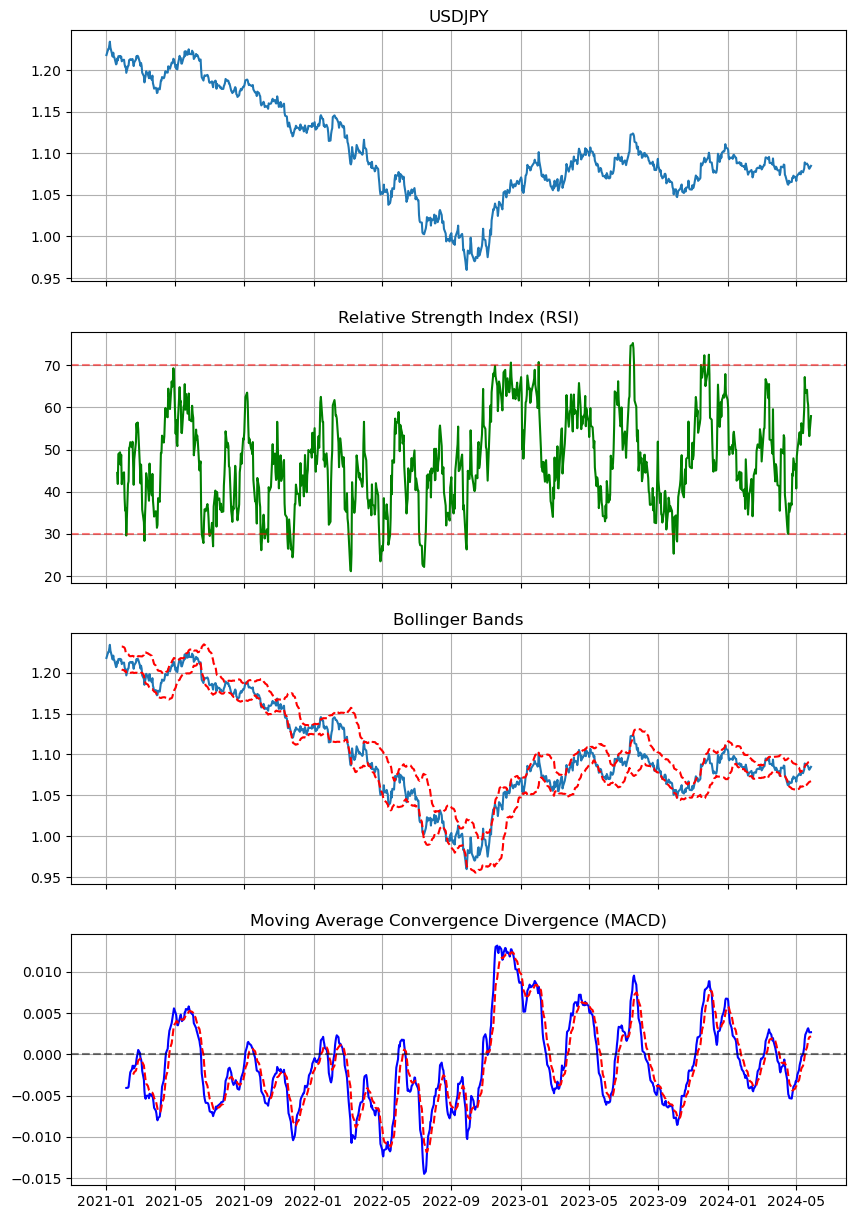

In [61]:
# Create subplots for each indicator
fig, axes = plt.subplots(4, 1, figsize=(10, 15),sharex=True)

# Plot closing price
axes[0].plot(df.index, df["Close"], label="Close")
axes[0].set_title("USDJPY")
axes[0].grid()

# Plot RSI
axes[1].plot(df.index, df["RSI"],label="RSI", color="g")
axes[1].axhline(30, linestyle="--", color="r",alpha=0.5)
axes[1].axhline(70, linestyle="--", color="r",alpha=0.5)
axes[1].set_title("Relative Strength Index (RSI)")
axes[1].grid()

# Plot Bollinger Bands
axes[2].plot(df.index,df["Close"], label="Close")
axes[2].plot(df.index,df["BB_upper"], label="Upper Bollinger Band", linestyle="--", color="r")
axes[2].plot(df.index,df["BB_lower"], label="Lower Bollinger Band", linestyle="--", color="r")
axes[2].set_title("Bollinger Bands")
axes[2].grid()

# Plot MACD
axes[3].plot(df.index, df["MACD"],label="MACD", color="b")
axes[3].plot(df.index, df["MACD_signal"], label="Signal Line",linestyle="--", color="r")
axes[3].axhline(0, linestyle="--", color="k", alpha=0.5)
axes[3].set_title("Moving Average Convergence Divergence (MACD)")
axes[3].grid()